In [45]:
# imports
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# from google.colab import drive
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier

In [1]:
#load the data file ass2.pickle

import pickle
import numpy as np

with open('ass2.pickle', 'rb') as f:
    data = pickle.load(f)

    

In [2]:
train = data['train']
test = data['test']
dev = data['dev']

# Data preprocessing and visualization

In [3]:
# Displaying the first 5 rows of the dataset
print(train.head())

# Getting the shape of the dataset
print(f"the shape of the train set{train.shape}")
print(f"the shape of the dev set{dev.shape}")
print(f"the shape of the test set{test.shape}")

print(train.describe())

       f0  f1  f2  f3  f4  f5  f6  f7  f8  f9  ...  f33  f34  f35  f36  f37  \
51905   1   0   0   0   0   0   2   1   2   2  ...    0    0    0    2    0   
52612   0   0   0   0   0   0   2   1   0   0  ...    0    0    0    2    0   
61699   2   1   2   1   1   0   2   2   0   0  ...    0    0    0    1    0   
6291    0   0   0   0   0   0   0   0   0   0  ...    0    0    0    2    0   
17484   0   0   0   0   0   0   1   1   2   0  ...    0    0    0    2    1   

       f38  f39  f40  f41  target  
51905    0    0    0    0       2  
52612    0    0    0    0       2  
61699    0    0    0    0       2  
6291     0    0    0    0       2  
17484    2    0    0    0       2  

[5 rows x 43 columns]
the shape of the train set(40533, 43)
the shape of the dev set(13512, 43)
the shape of the test set(13512, 43)
                 f0            f1            f2            f3            f4  \
count  40533.000000  40533.000000  40533.000000  40533.000000  40533.000000   
mean       0.9595

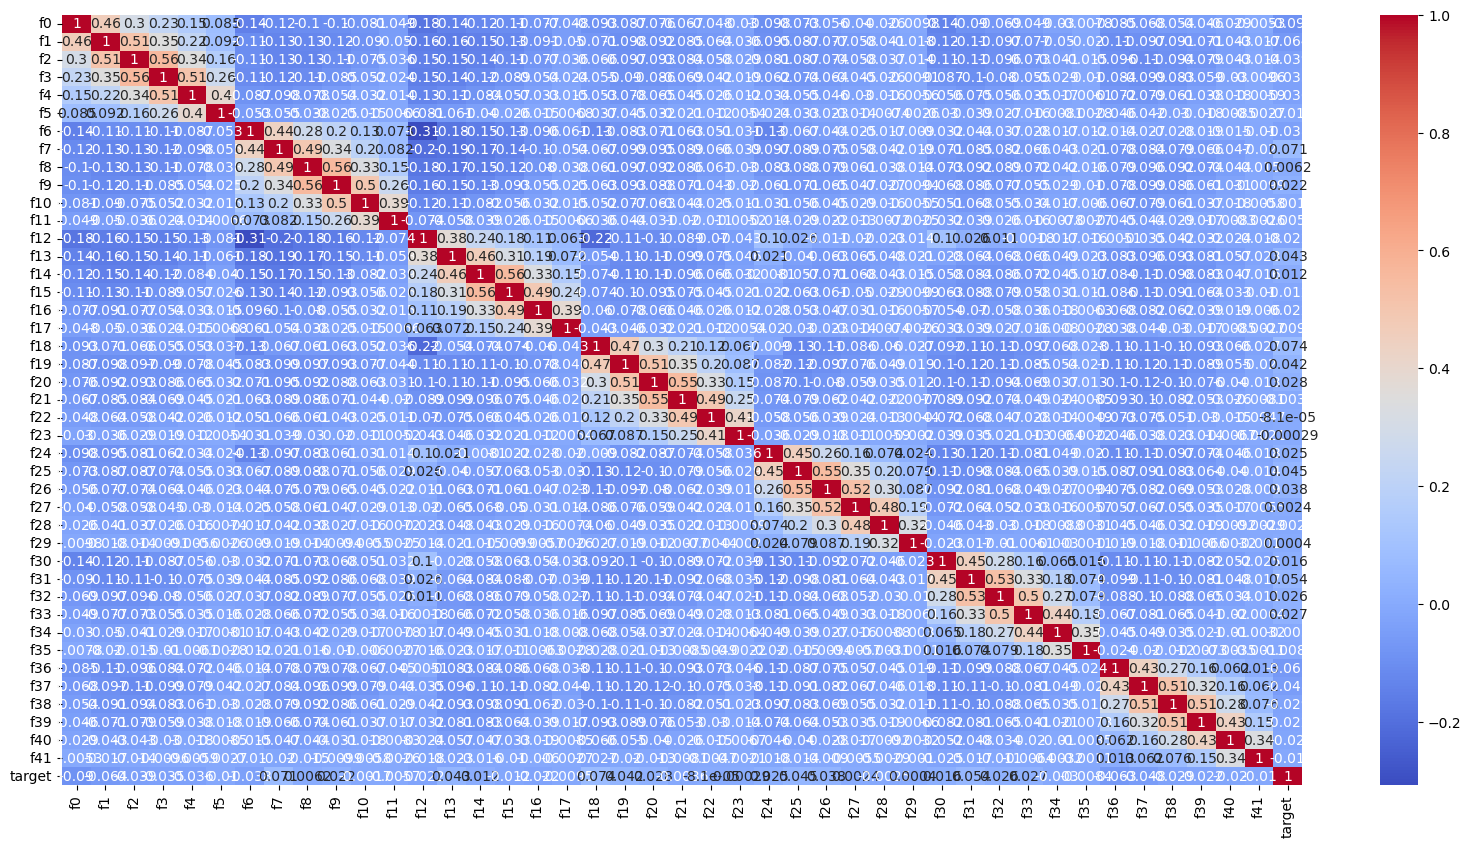

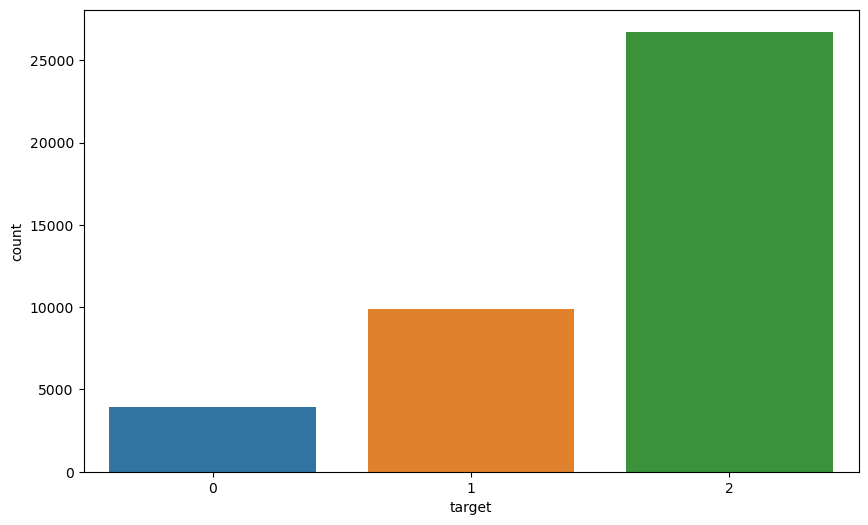

In [5]:
# Visualizing the correlation between the features
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')

# Visualizing the distribution of the target variable
plt.figure(figsize=(10,6))
sns.countplot(x='target', data=train)

plt.show()

# Model training and evaluation


In [6]:
X_train, X_dev, X_test = np.array(train.iloc[:, 1:-1]) ,  np.array(dev.iloc[:, 1:-1]), np.array(test.iloc[:, 1:-1])
y_train, y_dev, y_test = np.array(train.iloc[:, -1]), np.array(dev.iloc[:, -1]), np.array(test.iloc[:, -1])  

In [38]:
#utility functions

def undersample(X, y):
    '''
    Undersample the dataset to balance the classes
    '''
    ratio = Counter(y)
    strat = {0: min(ratio.values()), 1: min(ratio.values()), 2: min(ratio.values())}
    undersample = RandomUnderSampler(sampling_strategy=strat)
    X, y = undersample.fit_resample(X, y) 

    return X, y

def oversample(X, y):
    '''
    Oversample the dataset to balance the classes
    '''
    ratio = Counter(y)
    strat = {0: max(ratio.values()), 1: max(ratio.values()), 2: max(ratio.values())}
    oversample = RandomOverSampler(sampling_strategy=strat)
    X, y = oversample.fit_resample(X, y) 

    return X, y

def confusion_matrix_plt(y_true, y_pred):
    '''
    Plot the confusion matrix
    '''
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

## KNN

In [7]:
# Define range of values for number of neighbors to try
n_neighbors_range = range(1, 11)

# Initialize variables to store best parameters and score
best_n_neighbors = None
best_score = 0.0

# Try each number of neighbors in the range
for n_neighbors in tqdm(n_neighbors_range):
    # Create instance of KNeighborsClassifier with n_neighbors parameter
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the model on the training set
    knn.fit(X_train, y_train)
    
    # Evaluate the model on the validation set
    y_pred = knn.predict(X_dev)
    score = accuracy_score(y_dev, y_pred)
    
    # Update best parameters and score if the current score is better
    if score > best_score:
        best_n_neighbors = n_neighbors
        best_score = score

# Train the final model with the best hyperparameters on the entire training set
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(np.concatenate([X_train, X_dev]), np.concatenate([y_train, y_dev]))

# Evaluate the final model on the test set
y_pred = knn.predict(X_test)
final_score = accuracy_score(y_test, y_pred)

# Print the results
print('Best number of neighbors:', best_n_neighbors)
print('Validation accuracy:', best_score)
print('Final model accuracy:', final_score)

100%|██████████| 10/10 [03:25<00:00, 20.54s/it]


Best number of neighbors: 10
Validation accuracy: 0.7621373593842511
Final model accuracy: 0.7701302545885139


## Random Forest

In [11]:
# Define range of values for number of estimators and max depth to try
n_estimators_range = range(10, 51, 10)
max_depth_range = range(5, 26, 5)

# Initialize variables to store best parameters and score
best_n_estimators = None
best_max_depth = None
best_score = 0.0

# Initialize tqdm progress bar
pbar = tqdm(total=len(n_estimators_range) * len(max_depth_range))

# Try each combination of hyperparameters
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        # Update tqdm progress bar
        pbar.update(1)
        
        # Create instance of RandomForestClassifier with n_estimators and max_depth parameters
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        
        # Train the model on the training set
        rf.fit(X_train, y_train)
        
        # Evaluate the model on the validation set
        y_pred = rf.predict(X_dev)
        score = accuracy_score(y_dev, y_pred)
        
        # Update best parameters and score if the current score is better
        if score > best_score:
            best_n_estimators = n_estimators
            best_max_depth = max_depth
            best_score = score

# Close tqdm progress bar
pbar.close()

# Train the final model with the best hyperparameters on the entire dataset
rf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth)
rf.fit(np.concatenate([X_train, X_dev]), np.concatenate([y_train, y_dev]))

# Evaluate the final model on the test set
y_pred = rf.predict(X_test)
final_score = accuracy_score(y_test, y_pred)

# Print the results
print('Best number of estimators:', best_n_estimators)
print('Best max depth:', best_max_depth)
print('Best validation accuracy:', best_score)
print('Final model accuracy:', final_score)

100%|██████████| 25/25 [00:46<00:00,  1.87s/it]


Best number of estimators: 50
Best max depth: 25
Best validation accuracy: 0.7924067495559503
Final model accuracy: 0.7949230313795145


F1 score: 0.5965106501811066


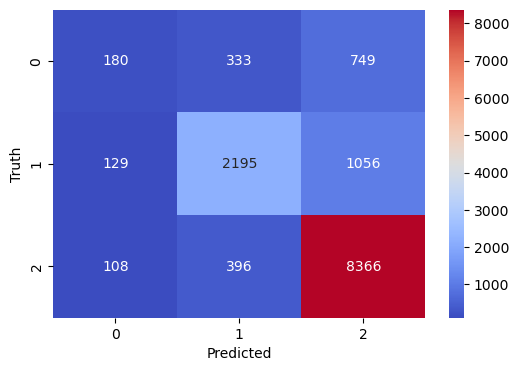

In [29]:
print('F1 score:', f1_score(y_test, y_pred, average='macro'))
confusion_matrix_plt(y_test, y_pred)

In [39]:
under_sample = undersample(np.concatenate([X_train, X_dev]), np.concatenate([y_train, y_dev]))
over_sample = oversample(np.concatenate([X_train, X_dev]), np.concatenate([y_train, y_dev]))

In [40]:
#lets run RF on the best hyperparameters from the previous step but on balanced dataset
# Train the final model with the best hyperparameters on the entire dataset
rf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth)
rf.fit(under_sample[0], under_sample[1])

preds = rf.predict(X_test)

F1 score: 0.5577102354816713
Accuracy score: 0.6408377738306691


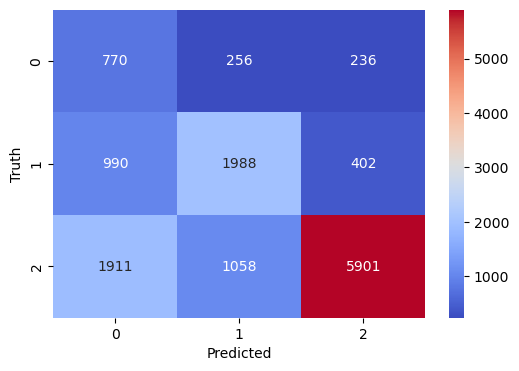

In [41]:
print('F1 score:', f1_score(y_test, preds, average='macro'))
print('Accuracy score:', accuracy_score(y_test, preds))
confusion_matrix_plt(y_test, preds)

## Logistic Regression

In [31]:
clf = LogisticRegression()

# Set up the hyperparameter search space
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear'],'class_weight':['balanced',None],}

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1,scoring=['accuracy','f1_micro','f1_macro'],verbose=1, refit="f1_macro")

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the best model on the dev set
best_lr_model = grid_search.best_estimator_
dev_score = best_lr_model.score(X_dev, y_dev)
print("Dev set score: ", dev_score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters:  {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best score:  0.3884447999469424
Dev set score:  0.6267021906453523


## XGBoost

In [34]:
def XGBoost(X_train, y_train, X_test,y_test, eta = 1, max_depth = 5, num_round = 100):
    '''
    Train and evaluate XGBoost model
    '''
    # Create DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Set XGBoost parameters
    param = {'eta': eta, 'max_depth': max_depth, 'objective': 'multi:softmax', 'num_class': 3}
    
    # Train the model
    bst = xgb.train(param, dtrain, num_round)
    
    # Make predictions on the test set
    preds = bst.predict(dtest)
    
    return preds

In [35]:
eta_range = [0.1,0.5,1]
max_depth_range = [5, 10, 20]
num_round_range = [1,10,50,100]

best_eta = None
best_max_depth = None
best_num_round = None
best_score = 0.0

# Initialize tqdm progress bar
pbar = tqdm(total=len(eta_range) * len(max_depth_range) * len(num_round_range))

# Try each combination of hyperparameters
for eta in eta_range:
    for max_depth in max_depth_range:
        for num_round in num_round_range:
            # Update tqdm progress bar
            pbar.update(1)
            
            # Make predictions on the test set
            preds = XGBoost(X_train, y_train, X_dev, y_dev, eta, max_depth, num_round)
            
            # Evaluate the model on the validation set
            score = accuracy_score(y_dev, preds)
            
            # Update best parameters and score if the current score is better
            if score > best_score:
                best_eta = eta
                best_max_depth = max_depth
                best_num_round = num_round
                best_score = score



100%|██████████| 36/36 [08:17<00:00, 17.90s/it]

In [42]:
print('Best eta:', best_eta)
print('Best max depth:', best_max_depth)
print('Best num round:', best_num_round)

Best eta: 0.5
Best max depth: 10
Best num round: 100


F1 score: 0.7051088687658761
Accuracy score: 0.8494671403197158


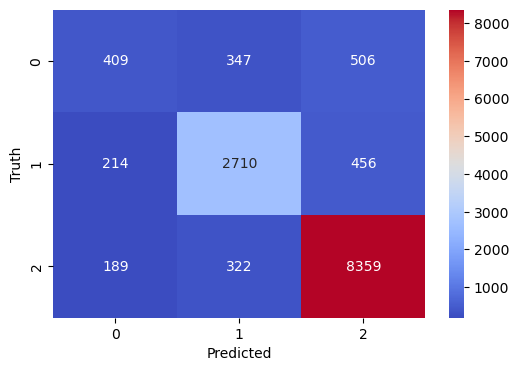

In [43]:
#train the model on the entire dataset with the best hyperparameters

preds = XGBoost(np.concatenate([X_train, X_dev]), np.concatenate([y_train, y_dev]), X_test, y_test, best_eta, best_max_depth, best_num_round)

print('F1 score:', f1_score(y_test, preds, average='macro'))
print('Accuracy score:', accuracy_score(y_test, preds))
confusion_matrix_plt(y_test, preds)

F1 score under sampled: 0.6501995149289129
Accuracy score under sampled: 0.7413410301953819


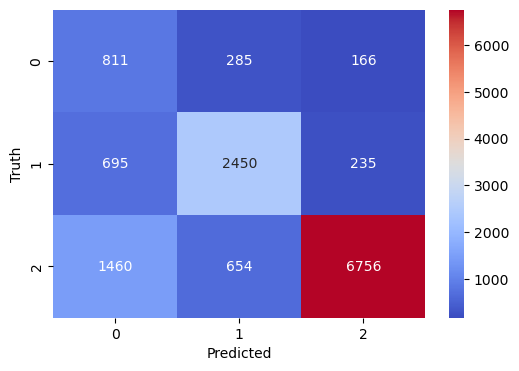

F1 score over sampled: 0.7078680936703341
Accuracy score over sampled: 0.8271166370633511


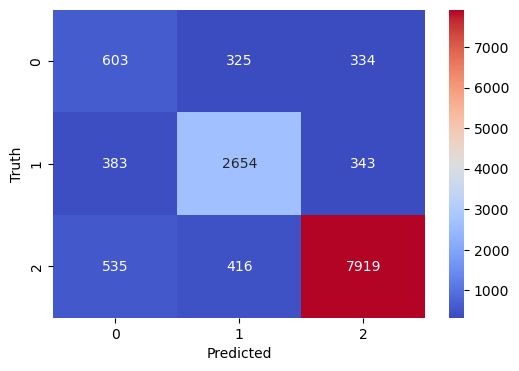

In [44]:
#lets try the best hyperparameters on the balanced dataset

preds_under = XGBoost(under_sample[0], under_sample[1], X_test, y_test, best_eta, best_max_depth, best_num_round)
preds_over = XGBoost(over_sample[0], over_sample[1], X_test, y_test, best_eta, best_max_depth, best_num_round)

print('F1 score under sampled:', f1_score(y_test, preds_under, average='macro'))
print('Accuracy score under sampled:', accuracy_score(y_test, preds_under))
confusion_matrix_plt(y_test, preds_under)

print('F1 score over sampled:', f1_score(y_test, preds_over, average='macro'))
print('Accuracy score over sampled:', accuracy_score(y_test, preds_over))
confusion_matrix_plt(y_test, preds_over)


## AdaBoost

In [48]:
def adaBoost(X_train, y_train, X_test,y_test, n_estimators = 50):
    '''
    Train and evaluate AdaBoost model
    '''
    # Create DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Set XGBoost parameters
    param = {'n_estimators': n_estimators}
    
    # Train the model
    bst = AdaBoostClassifier(**param)
    bst.fit(X_train, y_train)
    
    # Make predictions on the test set
    preds = bst.predict(X_test)
    
    return preds

In [49]:
num_estimators_range = range(1, 150, 15)

best_num_estimators = None
best_score = 0.0

# Initialize tqdm progress bar
pbar = tqdm(total=len(num_estimators_range))

for num_estimators in num_estimators_range:
    # Update tqdm progress bar
    pbar.update(1)
    
    # Make predictions on the test set
    preds = adaBoost(X_train, y_train, X_dev, y_dev, num_estimators)
    
    # Evaluate the model on the validation set
    score = accuracy_score(y_dev, preds)
    
    # Update best parameters and score if the current score is better
    if score > best_score:
        best_num_estimators = num_estimators
        best_score = score

100%|██████████| 10/10 [00:43<00:00,  7.31s/it]

Best num estimators: 136
F1 score: 0.4708407924842543
Accuracy score: 0.7400088809946714


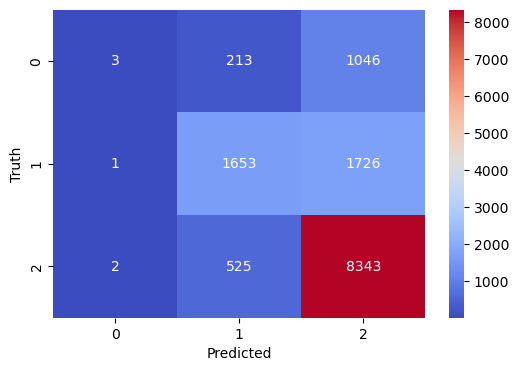

In [50]:
print('Best num estimators:', best_num_estimators)

#train the model on the entire dataset with the best hyperparameters

preds = adaBoost(np.concatenate([X_train, X_dev]), np.concatenate([y_train, y_dev]), X_test, y_test, best_num_estimators)
print('F1 score:', f1_score(y_test, preds, average='macro'))
print('Accuracy score:', accuracy_score(y_test, preds))
confusion_matrix_plt(y_test, preds)

F1 score under sampled: 0.6501995149289129
Accuracy score under sampled: 0.7413410301953819


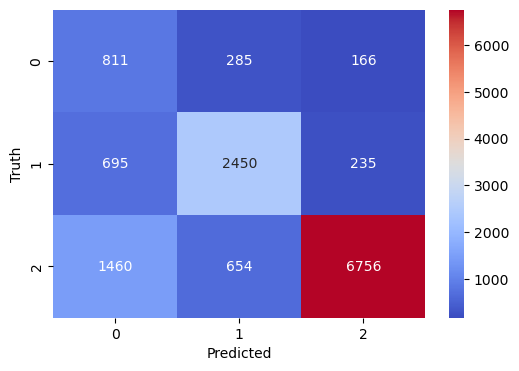

F1 score over sampled: 0.5307270339550375
Accuracy score over sampled: 0.6047957371225577


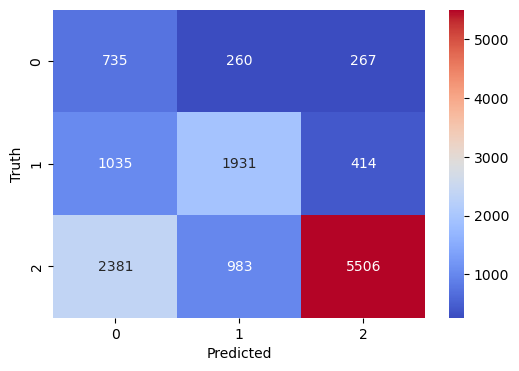

In [51]:
pereds_under = adaBoost(under_sample[0], under_sample[1], X_test, y_test, best_num_estimators)
preds_over = adaBoost(over_sample[0], over_sample[1], X_test, y_test, best_num_estimators)

print('F1 score under sampled:', f1_score(y_test, preds_under, average='macro'))
print('Accuracy score under sampled:', accuracy_score(y_test, preds_under))
confusion_matrix_plt(y_test, preds_under)

print('F1 score over sampled:', f1_score(y_test, preds_over, average='macro'))
print('Accuracy score over sampled:', accuracy_score(y_test, preds_over))
confusion_matrix_plt(y_test, preds_over)